<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/ML_scRNASeq_SK_lab_2020/Day3_00_Batch_Correction_and_Gene_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scprep phate magic-impute mnnpy scanpy

     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 122kB 8.9MB/s 
     |████████████████████████████████| 7.2MB 8.6MB/s 
     |████████████████████████████████| 419kB 42.6MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 122kB 35.6MB/s 
     |████████████████████████████████| 1.8MB 43.4MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
  Created wheel for mnnpy: filename=mnnpy-0.1.9.5-cp36-cp36m-linux_x86_64.whl size=260174 sha256=fa0655e35b3e9998b6809e88e2c25b2d6e4b5b366edbe8e7ce1112d9ba05edd2
  Stored in directory: /root/.cache/pip/wheels/99/4c/3a/c128d2a9903dd435b866281921158fa5f570e4f6db56b2a3dc
Successfully built mnnpy


In [0]:
import scprep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phate
import graphtools as gt
import magic
import os

# Batch correction and gene visualization

Here we're going to run batch correction on a two-batch dataset of peripheral blood mononuclear cells (PBMCs) from 10X Genomics. The two batches are from two healthy donors, one using the 10X version 2 chemistry, and the other using the 10X version 3 chemistry.

Note that in this case, we have no reason to believe that there would be a genuine biological difference between the two batches (both donors are healthy) and good reason to believe that would be a genuine technical difference between the two batches (they were run with different chemistries). You should only use batch correction if you are confident that the effect you are removing is not genuine biology.

## 1. Loading preprocessed data

We have loaded and preprocessed the PBMC data for you, though you can download the raw files from https://support.10xgenomics.com/single-cell-gene-expression/datasets

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that this is only useful if your data has two separate batches.

In [0]:
scprep.io.download.download_google_drive(id='1Ufsqot_Ir43M9XQhVNC27a6yW-_vvC9H',
                                         destination='data.pickle.gz')
scprep.io.download.download_google_drive(id='1BHji8Dy_jn8sIC60YsXm4sxVbFafnYWI',
                                         destination='metadata.pickle.gz')
data = pd.read_pickle('data.pickle.gz')
metadata = pd.read_pickle('metadata.pickle.gz')

## 2. Denoising with MAGIC

As mentioned previously, scRNAseq data suffers from various forms of noise - chiefly dropout or under counting of mRNA molecules in single cells. Since analysis of sparse, noisey and non-uniform expression data can be challenging, we impute missing data values with MAGIC. This will aid in the visualization of gene expression and later with more complex analyses.

Since PBMCs have 3 major cell types (T cells, B cells, and monocytes), we will selectively impute genes that are specific for this cell types. Selectively imputing genes helps save on memory.

In [4]:
marker_genes = scprep.select.get_gene_set(data, exact_word=['CD4', 'CD8A', 'CD19', 'ITGAX', 'CD14'])

data_magic = magic.MAGIC().fit_transform(data, genes=marker_genes)

Calculating MAGIC...
  Running MAGIC on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.92 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.67 seconds.
    Calculating affinities...
    Calculated affinities in 2.66 seconds.
  Calculated graph and diffusion operator in 16.15 seconds.
  Calculating imputation...
Calculated MAGIC in 18.34 seconds.


## 3. Characterizing the Batch Effect

Whenever you suspect there is a batch effect, you should always start by asking yourself, "How do I know this difference doesn't represent biologically relevant variation between samples?"

The best way to do this is to start by assessing which genes are most differentially expressed between samples. Here we'll use the differential expression toolkit implemented in [`scprep.stats.differential_expression`](scprep.stats.differential_expression). Another good toolkit for calculating differential expression is [DiffxPy](https://github.com/theislab/diffxpy/).

In [0]:
# Calculate the differential expression by calculating the t-statistic between samples
results = scprep.stats.differential_expression(data.loc[metadata['sample_labels'] == 'Donor_1'],
                                    data.loc[metadata['sample_labels'] == 'Donor_2'],
                                    measure='ttest')

#### Print out the top 20 genes differentially expressed between samples

In [6]:
results.shape

(10817, 2)

In [0]:
# ========
# Select the first 20 or 50 rows of the results dataframe
results.iloc[ ... ,:]
# ========

#### Plot the distribution of expression for each gene between samples
This plot is rather complicated so we're just going to give you the code to generate it.

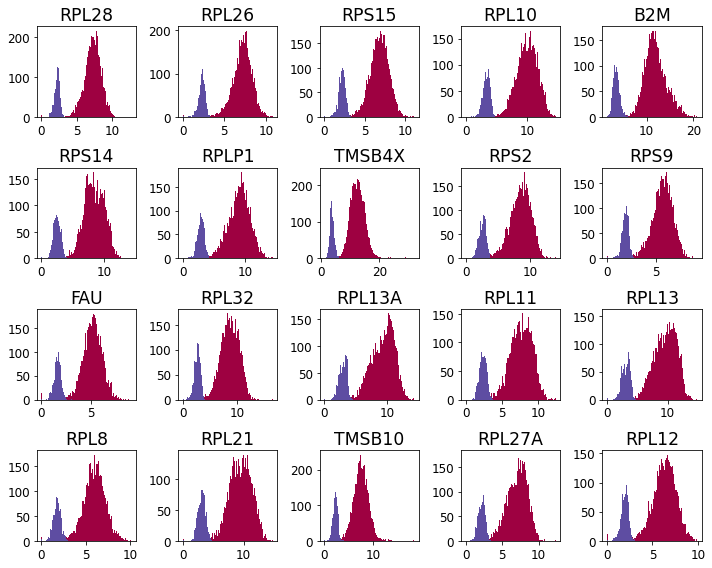

In [7]:
# Create the figure and subplot axes
fig, axes = plt.subplots(4,5, figsize=(2*5, 2*4))

# Iterate over the axes
for i, ax in enumerate(axes.flatten()):
    # Get the i'th most differentially expressed gene
    curr_gene = results.iloc[i].name
    # Split the gene name to get the symbol
    gene_symbol = curr_gene.split(' ')[0]
    
    # Get the raw expression for the current gene
    exp = np.array(data[curr_gene])
    
    # Get expression per sample
    exp_donor_1 = exp[metadata['sample_labels'] == 'Donor_1']
    exp_donor_2 = exp[metadata['sample_labels'] == 'Donor_2']
    
    # Plot the histograms
    scprep.plot.histogram(exp_donor_1, range=(exp.min(), exp.max()), bins=100, 
                          ax=ax, color='#9E0141', ylabel='')
    scprep.plot.histogram(exp_donor_2, range=(exp.min(), exp.max()), bins=100, 
                          ax=ax, color='#5E4DA2', ylabel='', title=gene_symbol)

# Fit subplots into figure neatly
fig.tight_layout()

### Discussion

1. What do you notice about the kinds of genes that are the top 20 or 50 differentially expressed between samples?    

2. Do you think these differences are biologically relevant? What sort of technical factors could influence the detection of these genes?

## 4. Visualizing data

Here, we're going to visualize our data with PHATE. If you'd like to use other visualization techniques such as UMAP or tSNE please go ahead!

In [8]:
data_phate = phate.PHATE().fit_transform(data)
# alternative: umap.UMAP(), sklearn.manifold.TSNE()

Calculating PHATE...
  Running PHATE on 5199 observations and 10817 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.91 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.81 seconds.
    Calculating affinities...
    Calculated affinities in 0.57 seconds.
  Calculated graph and diffusion operator in 13.64 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.94 seconds.
    Calculating KMeans...
  Calculated landmark operator in 29.28 seconds.
  Calculating optimal t...
    Automatically selected t = 26
  Calculated optimal t in 5.45 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.10 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.30 seconds.
Calculated PHATE in 60.80 seconds.


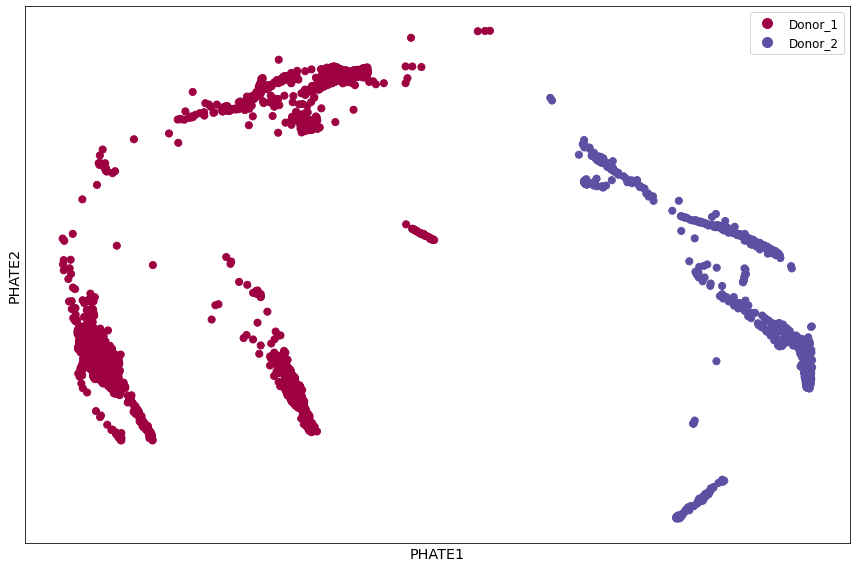

In [9]:
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", s = 50)

### Discussion

1. What do you notice about this visualization? 
2. What do you think is driving this effect?

## 5. Visualizing imputed gene expression on visualization

To check our suspicions about this dataset, let's check some cell type specific markers.

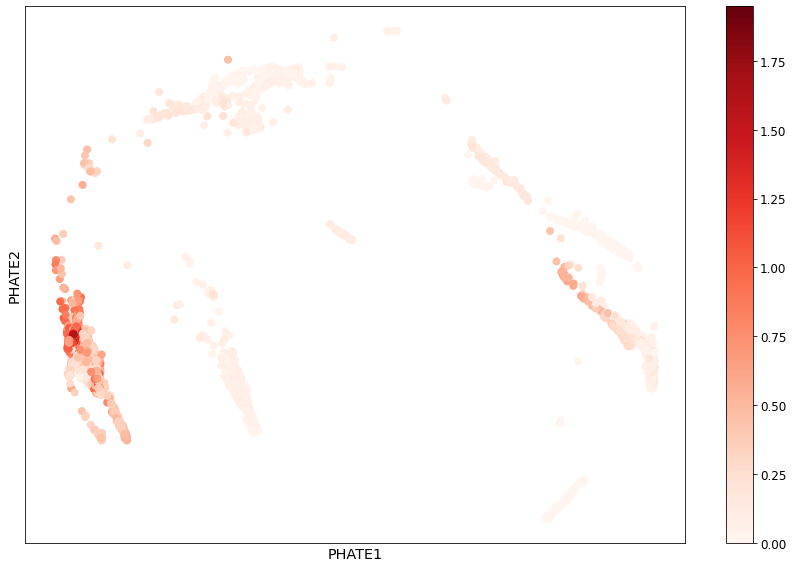

In [11]:
expression = scprep.select.select_cols(data_magic, exact_word='CD8A')

scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

### Exercise - plotting gene expression

Visualize each of the following marker genes and describe what you find: CD4, CD8A, CD19, ITGAX, CD14. Try using both raw and imputed data.

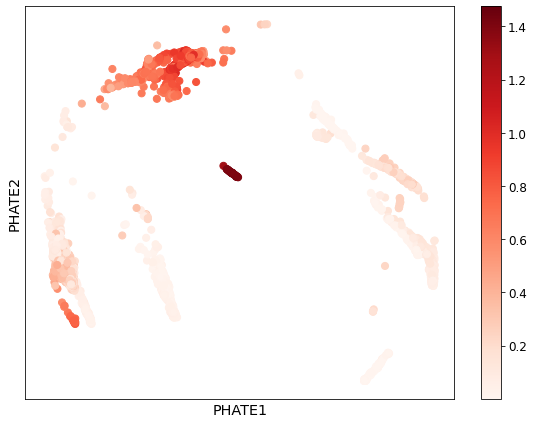

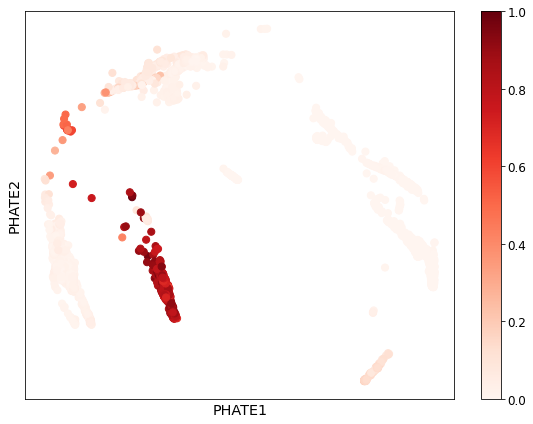

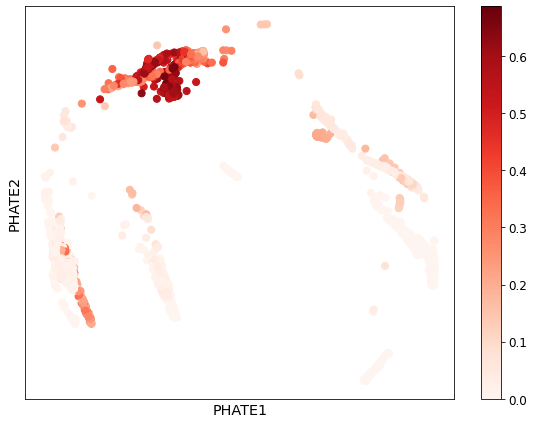

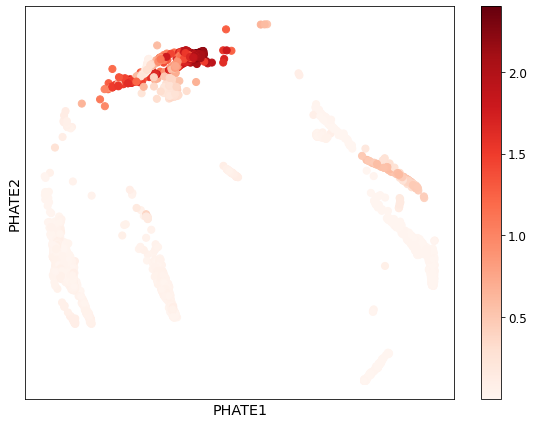

In [14]:
# ===========
# Extract the gene expression for each of the genes listed from either `data` or `data_magic`
expression = scprep.select.select_cols(data_magic, exact_word='CD4')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(8,6), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

expression = scprep.select.select_cols(data_magic, exact_word='CD19')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(8,6), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

expression = scprep.select.select_cols(data_magic, exact_word='ITGAX')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(8,6), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

expression = scprep.select.select_cols(data_magic, exact_word='CD14')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(8,6), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)


### Discussion

1. What do you notice about the expression of each of these markers?
2. What else might you check before deciding that the difference between the batches is a technical effect?

## 6. Correcting differences between samples

There are several algorithms that try to correct systemic sample level differences present in single cell datasets. Here, we will implement MNN correction to try and remove these differences. Herein, we will first create an AnnData object from our data before running it through MNN to get corrected data. We can then use this data to re-impute gene expression and re-visualize our data.

In [0]:
import scanpy as sc

pbmc_anndata = sc.AnnData(X=data, obs = metadata)

In [0]:
batches = ["Donor_1","Donor_2"]
alldata = {}

for batch in batches:
    alldata[batch] = pbmc_anndata[pbmc_anndata.obs['sample_labels']==batch,]


In [17]:
cdata = sc.external.pp.mnn_correct(alldata['Donor_1'], alldata['Donor_2'], svd_dim=50, 
                                  batch_key = 'sample_labels', batch_categories=["Donor_1","Donor_2"])

/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7ff5cf246e18>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7ff5cf246e18>)
[2] During: typing of call at /usr/local/lib/python3.6/dist-packages/mnnpy/utils.py (16)


File "../usr/local/lib/python3.6/dist-

Performing cosine normalization...


/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x7ff5cf246e18>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from /usr/local/lib/python3.6/dist-packages/numba/typing/templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x7ff5cf246e18>)
[2] During: typing of call at /usr/local/lib/python3.6/dist-packages/mnnpy/utils.py (16)


File "../usr/local/lib/python3.6/dist-

Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at /usr/local/lib/python3.6/dist-packages/mnnpy/utils.py (94)

File "../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  state.func_ir.loc))
/usr/loca

  Computing correction vectors...


/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.6/dist-packages/mnnpy/utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.6/dist-packages/mnnpy/utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function compute_correction failed at nopython mode lowering due to: iterating over 2D array

File "../usr

  Removing components...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


## 7. Visualizing gene expression on corrected data

Now that we have a batch corrected dataset, let's visualize imputed gene expression on the aligned manifold. Let us know what you think!

In [18]:
cdata_magic = magic.MAGIC().fit_transform(cdata[0], genes=marker_genes)

cdata_magic = pd.DataFrame(cdata_magic.X)
cdata_magic.columns = marker_genes
cdata_index = data.index

Calculating MAGIC...
  Running MAGIC on 5199 cells and 10817 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.66 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.44 seconds.
    Calculating affinities...
    Calculated affinities in 3.42 seconds.
  Calculated graph and diffusion operator in 13.54 seconds.
  Calculating imputation...
Calculated MAGIC in 13.65 seconds.


In [19]:
cdata_phate = phate.PHATE().fit_transform(cdata[0])

Calculating PHATE...
  Running PHATE on 5199 observations and 10817 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.36 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.59 seconds.
    Calculating affinities...
    Calculated affinities in 0.73 seconds.
  Calculated graph and diffusion operator in 10.71 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.02 seconds.
    Calculating KMeans...
    Calculated KMeans in 34.85 seconds.
  Calculated landmark operator in 37.26 seconds.
  Calculating optimal t...
    Automatically selected t = 20
  Calculated optimal t in 5.20 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.62 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 9.58 seconds.
Calculated PHATE in 65.40 seconds.


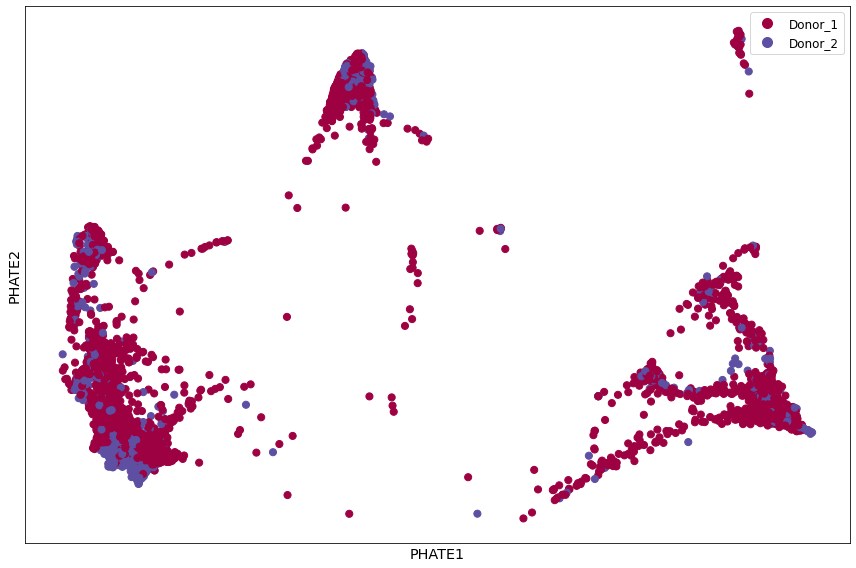

In [20]:
scprep.plot.scatter2d(cdata_phate, c=metadata['sample_labels'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE", s = 50)

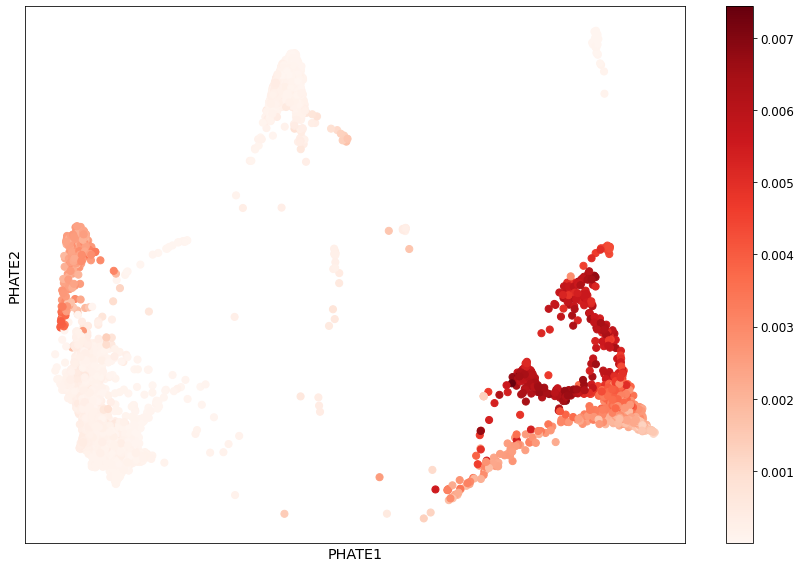

In [21]:
expression = scprep.select.select_cols(cdata_magic, exact_word='ITGAX') # Please enter each of the marker genes here

scprep.plot.scatter2d(cdata_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

### Exercise - plotting gene expression

Visualize each of the following marker genes and describe what you find: CD4, CD8A, CD19, ITGAX, CD14. Try using both raw and imputed data.

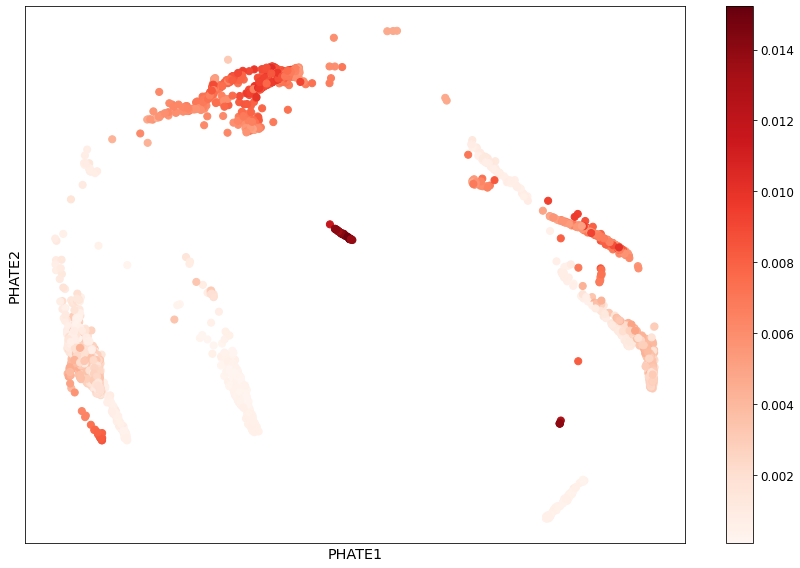

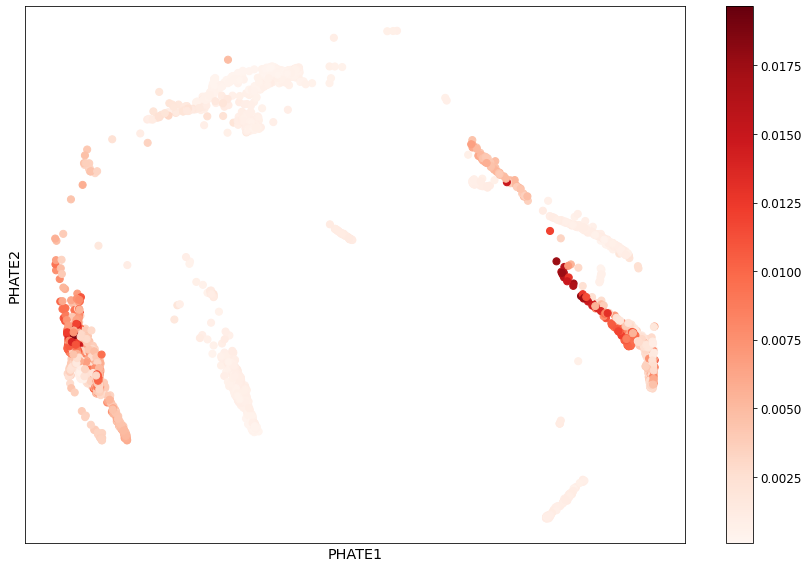

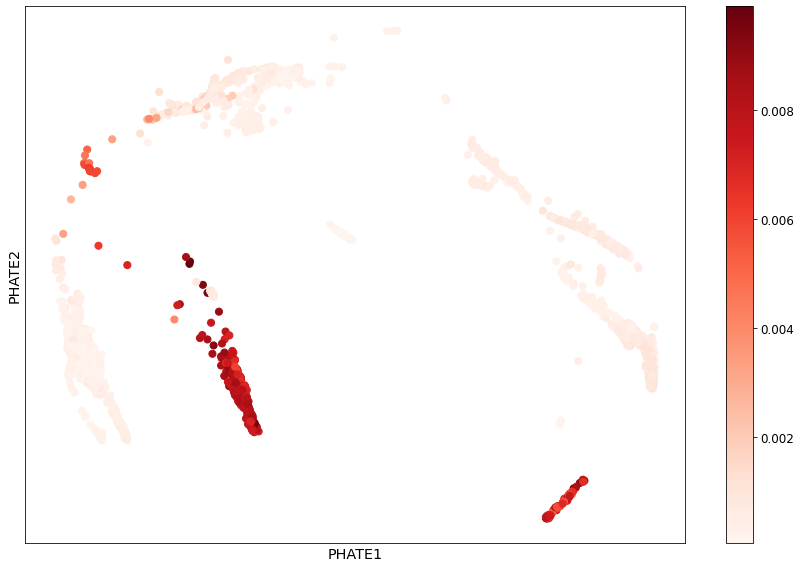

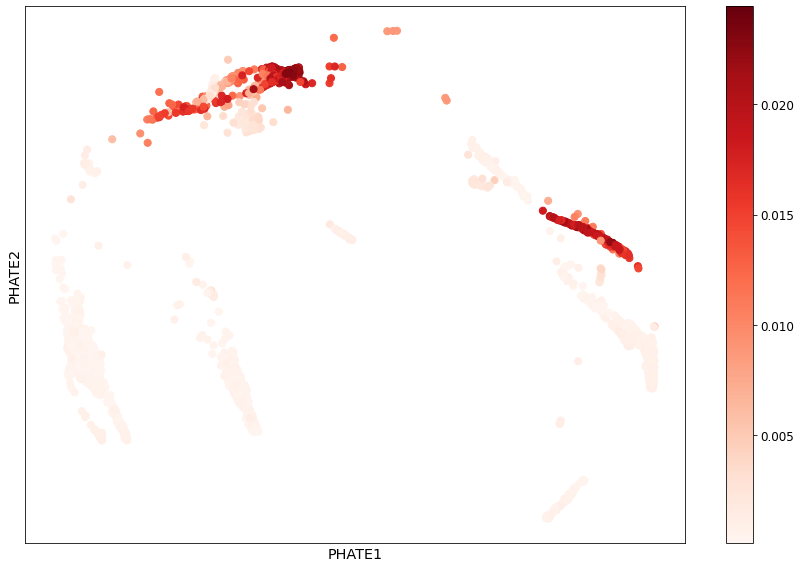

In [22]:
# ===========
# Extract the gene expression for each of the genes listed from either `data` or `data_magic`
expression = scprep.select.select_cols(cdata_magic, exact_word='CD4')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

expression = scprep.select.select_cols(cdata_magic, exact_word='CD8A')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

expression = scprep.select.select_cols(cdata_magic, exact_word='CD19')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)

expression = scprep.select.select_cols(cdata_magic, exact_word='CD14')
# ===========
scprep.plot.scatter2d(data_phate, c=expression, figsize=(12,8), cmap="Reds",
                      ticks=False, label_prefix="PHATE", s = 50)


### Discussion

1. What do you notice about the expression of each of these markers? How does it compare to the visualization before batch correction?
2. When is it a good idea to apply batch correction to a dataset?
3. Can you think of any risks of doing batch correction?